# Problem Statement

### Create a predictive model which will help the customers to predict future flight prices and plan their journey accordingly.

#### Features

Airline: The name of the airline.

Date_of_Journey: The date of the journey

Source: The source from which the service begins.

Destination: The destination where the service ends.

Route: The route taken by the flight to reach the destination.

Dep_Time: The time when the journey starts from the source.

Arrival_Time: Time of arrival at the destination.

Duration: Total duration of the flight.

Total_Stops: Total stops between the source and destination.

Additional_Info: Additional information about the flight

Price: The price of the ticket

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Loading Dataset

In [2]:
# Make sure the dataset file and jupyter notebook must have same directory 
data=pd.read_excel("Flight_Fare_Prediction.xlsx")

In [3]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


# Basic Checks

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [5]:
data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


# Feature Engineering
- Handling feature indicating time

### Date of Journey

- Extracting day and month from the "Date_of_Journey" feature and dividing it into two features.
- As all data is from the year 2019, year will not have any effect on final price.

In [6]:
data["Day_of_Journey"] = data['Date_of_Journey'].str.split('/').str[0].astype(int)
data["Month_of_Journey"] = data['Date_of_Journey'].str.split('/').str[1].astype(int)
data.drop(["Date_of_Journey"], axis = 1, inplace = True)

### Departure time & Arrival time

- we can also bifurcate departure time and arrival time into hours and mins using to_datetime function in pandas

In [7]:
data["Dep_Hour"] = pd.to_datetime(data["Dep_Time"]).dt.hour
data["Dep_Min"] = pd.to_datetime(data["Dep_Time"]).dt.minute
data.drop(["Dep_Time"], axis = 1, inplace = True)

In [8]:
data["Arr_Hour"] = pd.to_datetime(data["Arrival_Time"]).dt.hour
data["Arr_Min"] = pd.to_datetime(data["Arrival_Time"]).dt.minute
data.drop(["Arrival_Time"], axis = 1, inplace = True)

### Duration

- we can also split duration into duration hours and duration minutes

In [9]:
duration = list(data['Duration']) # convert to list 

for i in range(len(duration)):
    if len(duration[i].split())!=2:
        if "h" in duration[i]:
            duration[i] = duration[i].strip()+' 0m'
        else:
            duration[i]= "0h "+duration[i]
            
duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep="h")[0]))
    duration_mins.append(int(duration[i].split(sep="m")[0].split()[-1]))

In [10]:
data['Duration_hours']= duration_hours
data['Duration_min']= duration_mins
data.drop(["Duration"],axis=1, inplace = True)

# Handling Total Stops feature

- As this feature has ordinal categorical data, we will perform manual label encoding on it.

In [11]:
data.Total_Stops.unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', nan, '4 stops'],
      dtype=object)

In [12]:
data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

In [13]:
# Let's take a look at features before moving on to perform EDA.
data.head(4)

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_Hour,Dep_Min,Arr_Hour,Arr_Min,Duration_hours,Duration_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,0.0,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2.0,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2.0,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1.0,No info,6218,12,5,18,5,23,30,5,25


# Exploratory Data Analysis

### Airline

In [14]:
data.Airline.unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

In [15]:
data.Airline.value_counts()

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64

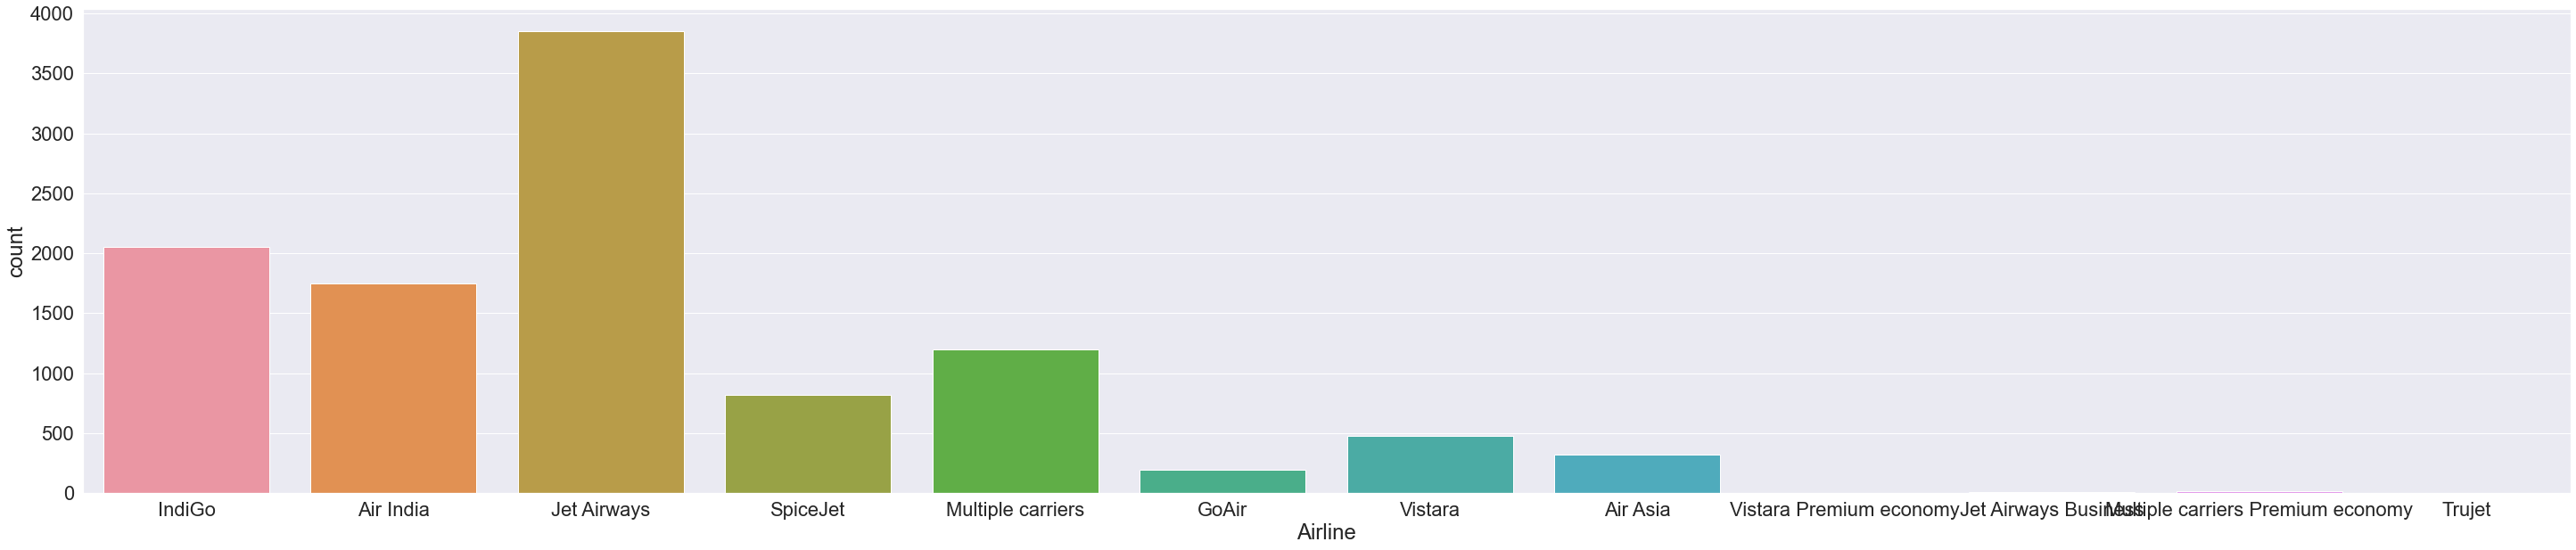

In [16]:
plt.figure(figsize=(50,10))
sns.set(font_scale=2)
sns.countplot(x="Airline",data=data)
plt.show()

- Jet airways Airlines runs highest number of flights out of all flights.
- There are very Few Premium class flights.

<Figure size 3600x720 with 0 Axes>

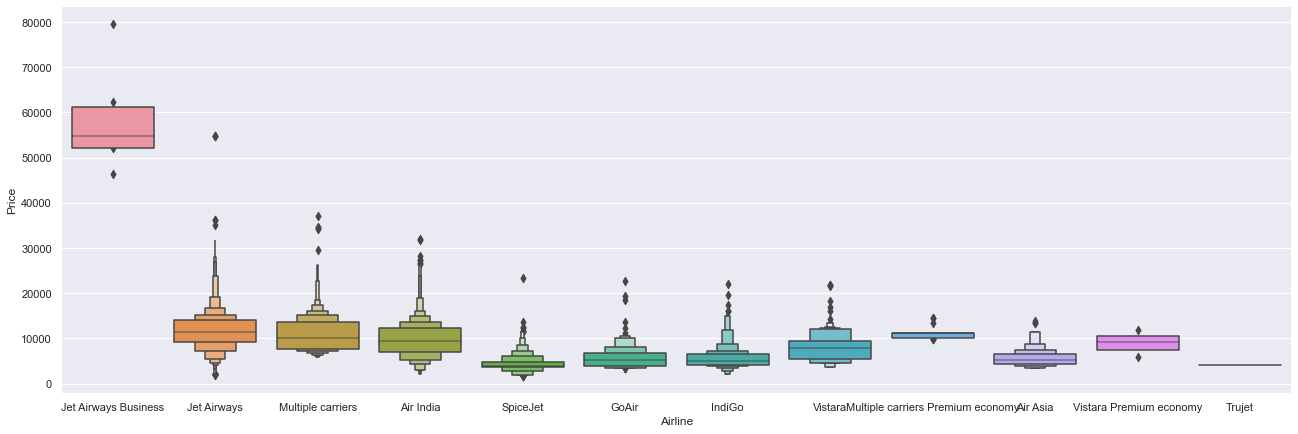

In [17]:
plt.figure(figsize=(50,10))
sns.set(font_scale=1)
sns.catplot(y="Price",x="Airline",data=data.sort_values('Price',ascending=False),kind="boxen", height=6,aspect=3)
plt.show()

- Jet airways and Air India are highly priced.
- Low-cost carriers like indigo and spicejet have a lower and similar fare range.
- Jet Airways Business has the highest Price among all airlines.

### Source

In [18]:
data.Source.unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

In [19]:
data.Source.value_counts()

Source
Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: count, dtype: int64

<AxesSubplot:xlabel='Source', ylabel='count'>

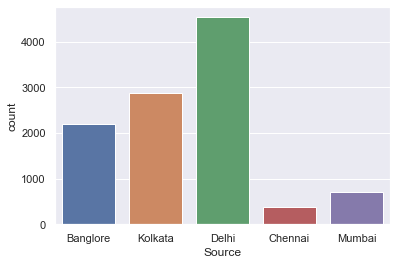

In [20]:
sns.countplot('Source',data=data)

- Maximum flight depart from Delhi followed by Kolkata.

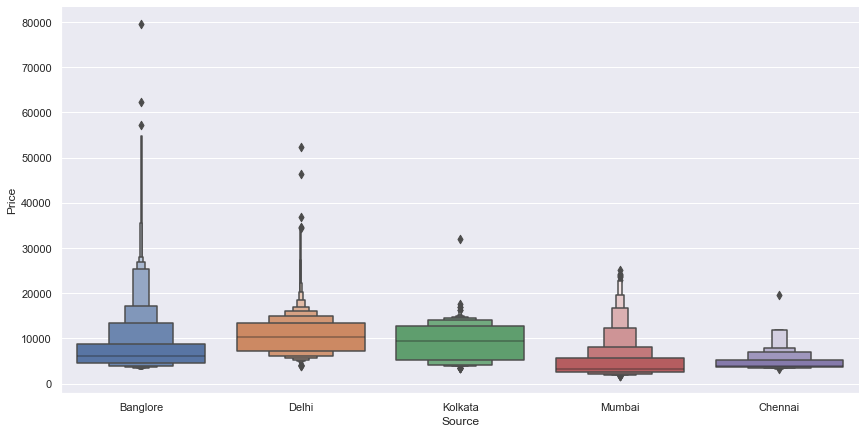

In [21]:
sns.catplot(y="Price",x="Source",data= data.sort_values('Price',ascending=False),kind="boxen",height=6, aspect=2)

- Based upon Source location Maximum Fare Comes for Banglore flight.

### Destination

In [22]:
data.Source.unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

- New Delhi and Delhi are same, so let's replace New Delhi with Delhi

In [23]:
data["Destination"] = data["Destination"].replace("New Delhi","Delhi")

In [24]:
data.Source.value_counts()

Source
Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: count, dtype: int64

<AxesSubplot:xlabel='Destination', ylabel='count'>

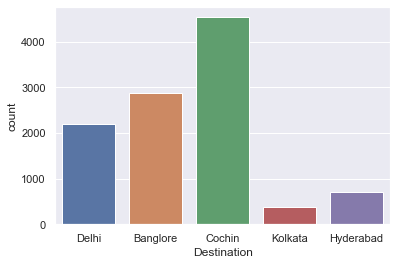

In [25]:
sns.countplot("Destination",data=data)

- Maximum Flights lands into cochin followed by Banglore.

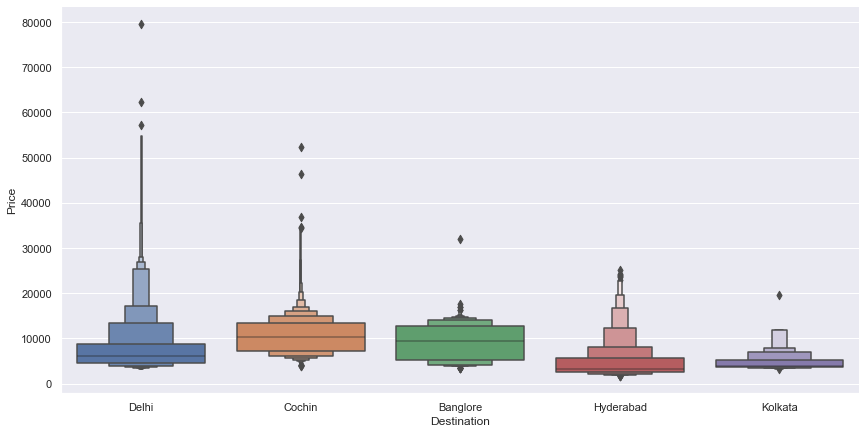

In [26]:
sns.catplot(y="Price",x="Destination",data= data.sort_values('Price',ascending=False),kind="boxen",height=6, aspect=2)

- The flight ticket price range in Delhi is the maximum, reason may be the National Capital.

### Duration

<AxesSubplot:xlabel='Duration_hours', ylabel='Price'>

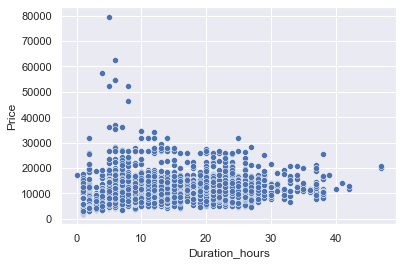

In [27]:
sns.scatterplot(x="Duration_hours",y="Price",data=data)

<AxesSubplot:xlabel='Duration_min', ylabel='Price'>

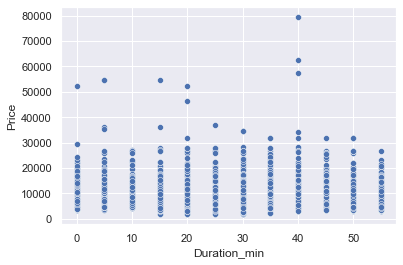

In [28]:
sns.scatterplot(x="Duration_min",y="Price",data=data)

- Duration plays a major role in affecting air ticket prices but there is no such pattern here.

### TotalStops

<AxesSubplot:xlabel='Total_Stops', ylabel='Price'>

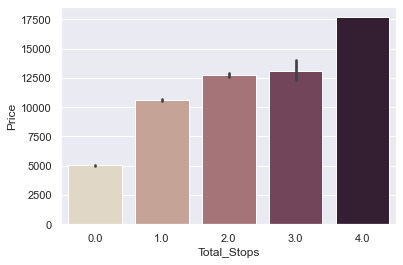

In [29]:
sns.barplot(data["Total_Stops"],data["Price"],data=data,palette="ch:.28")

- As a direct/non-stop flight is accounting for fare of only one flight for a trip, its average fair is the least. As the no. of stops/layovers increase, the fare price goes up accounting for no. of flights and due to other resources being used up for the same.

### Journey day, Deaparture time, Arrival time

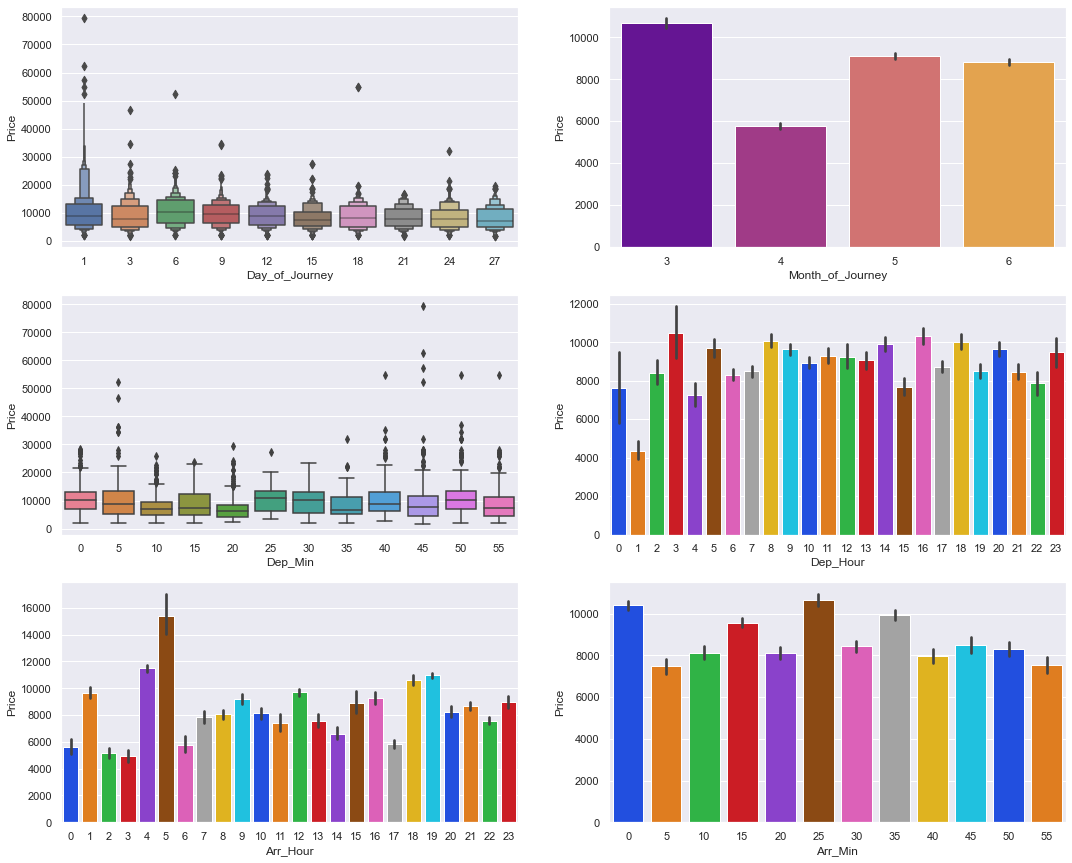

In [30]:
fig, axes = plt.subplots(3,2,figsize=(18,15))

# Checking relation between Journey_Day and Price
sns.boxenplot(x="Day_of_Journey",y="Price",ax = axes[0,0],data=data)

# Checking relation between Journey_Mionth and Price
sns.barplot(x="Month_of_Journey",y="Price",ax = axes[0,1],data=data,palette='plasma')

# Checking relation between Dep_Min and Price
sns.boxplot(x="Dep_Min",y="Price",ax=axes[1,0],data=data,palette='husl')

# Checking relation between Dep_Hour and Price
sns.barplot(x="Dep_Hour",y="Price",ax=axes[1,1],data=data,palette="bright")

# Checking relation between Arr_Hour and Price
sns.barplot(x="Arr_Hour",y="Price",ax=axes[2,0],data=data,palette="bright")

# Checking relation between Arr_min and Price
sns.barplot(x="Arr_Min",y="Price",ax=axes[2,1],data=data,palette="bright")
plt.show()

- Airfare is high on Day 3 followed by Day 16 of every month.
- March month is most expensive to tarvel bya air while airfare is least expensive in April month.
- Flight arriving at destination during the first light hours (4am & 5am) are expensive.

# Data Preprocessing

### Checking for Null Values

In [31]:
data.isnull().sum()

Airline             0
Source              0
Destination         0
Route               1
Total_Stops         1
Additional_Info     0
Price               0
Day_of_Journey      0
Month_of_Journey    0
Dep_Hour            0
Dep_Min             0
Arr_Hour            0
Arr_Min             0
Duration_hours      0
Duration_min        0
dtype: int64

In [32]:
data.loc[data.Route.isnull()]

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_Hour,Dep_Min,Arr_Hour,Arr_Min,Duration_hours,Duration_min
9039,Air India,Delhi,Cochin,NaN,NaN,No info,7480,6,5,9,45,9,25,23,40


### Droping null values

In [33]:
data.dropna(inplace=True)

In [34]:
data.isnull().sum()

Airline             0
Source              0
Destination         0
Route               0
Total_Stops         0
Additional_Info     0
Price               0
Day_of_Journey      0
Month_of_Journey    0
Dep_Hour            0
Dep_Min             0
Arr_Hour            0
Arr_Min             0
Duration_hours      0
Duration_min        0
dtype: int64

### Checking duplicate Values

In [35]:
data[data.duplicated()]

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_Hour,Dep_Min,Arr_Hour,Arr_Min,Duration_hours,Duration_min
683,Jet Airways,Delhi,Cochin,DEL → NAG → BOM → COK,2.0,No info,13376,1,6,14,35,4,25,13,50
1061,Air India,Delhi,Cochin,DEL → GOI → BOM → COK,2.0,No info,10231,21,5,22,0,19,15,21,15
1348,Air India,Delhi,Cochin,DEL → HYD → BOM → COK,2.0,No info,12392,18,5,17,15,19,15,26,0
1418,Jet Airways,Delhi,Cochin,DEL → JAI → BOM → COK,2.0,In-flight meal not included,10368,6,6,5,30,4,25,22,55
1674,IndiGo,Banglore,Delhi,BLR → DEL,0.0,No info,7303,24,3,18,25,21,20,2,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10594,Jet Airways,Delhi,Cochin,DEL → AMD → BOM → COK,2.0,No info,12819,27,6,23,5,12,35,13,30
10616,Jet Airways,Delhi,Cochin,DEL → JAI → BOM → COK,2.0,No info,13014,1,6,9,40,12,35,26,55
10634,Jet Airways,Delhi,Cochin,DEL → JAI → BOM → COK,2.0,In-flight meal not included,11733,6,6,9,40,12,35,26,55
10672,Jet Airways,Delhi,Cochin,DEL → AMD → BOM → COK,2.0,In-flight meal not included,11150,27,6,23,5,19,0,19,55


### Dropping duplicate values

In [36]:
data.drop_duplicates(keep='first',inplace=True)

### Handling categorical data to numerical data

- OneHotEncoding for Airline, Source, Destination.

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10460 entries, 0 to 10682
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Airline           10460 non-null  object 
 1   Source            10460 non-null  object 
 2   Destination       10460 non-null  object 
 3   Route             10460 non-null  object 
 4   Total_Stops       10460 non-null  float64
 5   Additional_Info   10460 non-null  object 
 6   Price             10460 non-null  int64  
 7   Day_of_Journey    10460 non-null  int32  
 8   Month_of_Journey  10460 non-null  int32  
 9   Dep_Hour          10460 non-null  int32  
 10  Dep_Min           10460 non-null  int32  
 11  Arr_Hour          10460 non-null  int32  
 12  Arr_Min           10460 non-null  int32  
 13  Duration_hours    10460 non-null  int64  
 14  Duration_min      10460 non-null  int64  
dtypes: float64(1), int32(6), int64(3), object(5)
memory usage: 1.0+ MB


In [38]:
# As Airline is Nominal Categorical data we will perform OneHotEncoding

Airline = data[["Airline"]]

Airline = pd.get_dummies(Airline, drop_first= True).astype(int)

Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [39]:
# As Source is Nominal Categorical data we will perform OneHotEncoding

Source = data[["Source"]]

Source = pd.get_dummies(Source, drop_first= True).astype(int)

Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [40]:
# As Destination is Nominal Categorical data we will perform OneHotEncoding

Destination = data[["Destination"]]

Destination = pd.get_dummies(Destination, drop_first = True).astype(int)

Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,1,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,1,0,0


In [41]:
data.Additional_Info.value_counts()

Additional_Info
No info                         8180
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: count, dtype: int64

In [42]:
data.Route.value_counts

<bound method IndexOpsMixin.value_counts of 0                    BLR → DEL
1        CCU → IXR → BBI → BLR
2        DEL → LKO → BOM → COK
3              CCU → NAG → BLR
4              BLR → NAG → DEL
                 ...          
10678                CCU → BLR
10679                CCU → BLR
10680                BLR → DEL
10681                BLR → DEL
10682    DEL → GOI → BOM → COK
Name: Route, Length: 10460, dtype: object>

- Additional_Info contains almost 80% of no_info.
- Route and Total_Stops are related to each other.
- Hence, We will proceed with dropping these two features.

In [43]:
data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [44]:
# Concatenate dataframe --> data + Airline + Source + Destination
data_processed = pd.concat([data, Airline, Source, Destination], axis = 1)

In [45]:
# Drop 
data_processed.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [46]:
data_processed.head()

,Total_Stops,Price,Day_of_Journey,Month_of_Journey,Dep_Hour,Dep_Min,Arr_Hour,Arr_Min,Duration_hours,Duration_min,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0.0,3897,24,3,22,20,1,10,2,50,...,0,0,0,0,0,0,0,1,0,0
1,2.0,7662,1,5,5,50,13,15,7,25,...,0,0,0,0,1,0,0,0,0,0
2,2.0,13882,9,6,9,25,4,25,19,0,...,0,0,0,1,0,0,1,0,0,0
3,1.0,6218,12,5,18,5,23,30,5,25,...,0,0,0,0,1,0,0,0,0,0
4,1.0,13302,1,3,16,50,21,35,4,45,...,0,0,0,0,0,0,0,1,0,0


# Feature Selection

### Checking Correlation

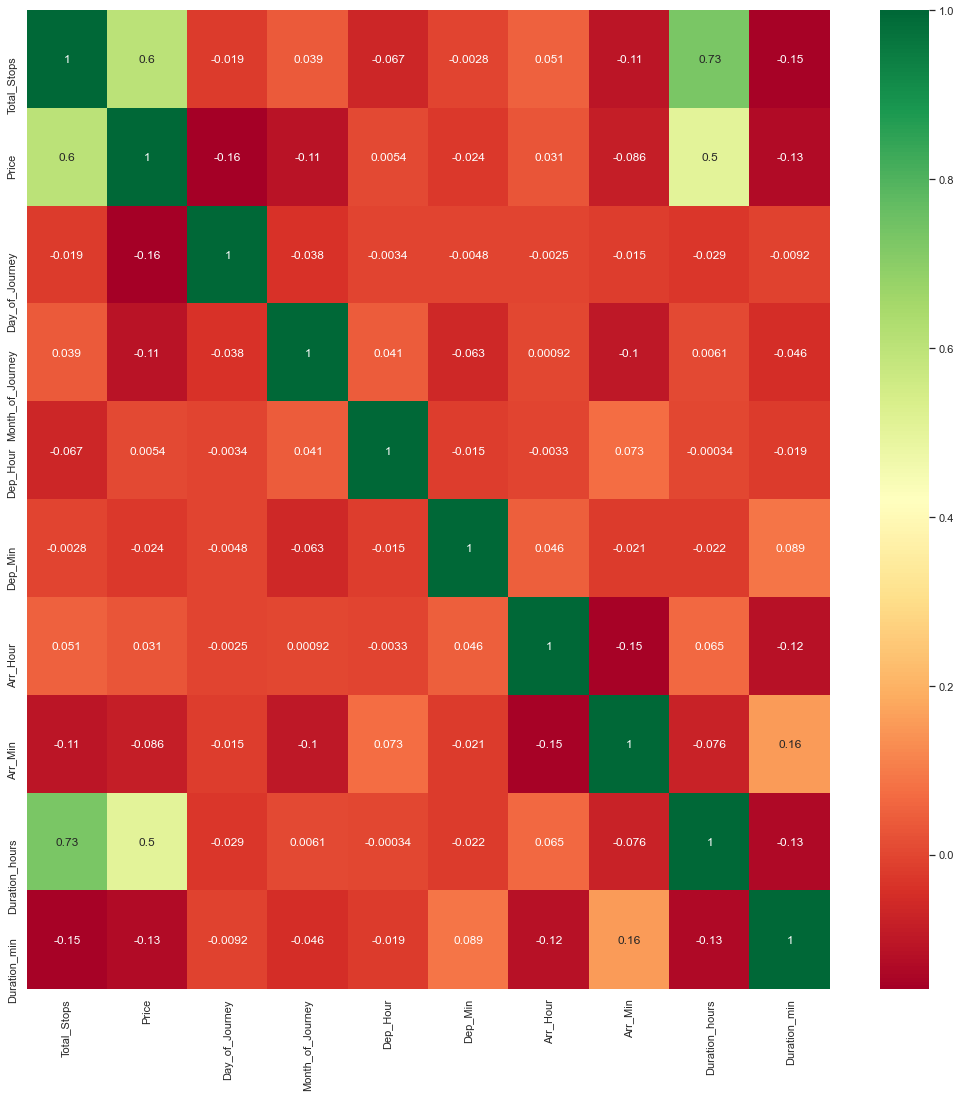

In [47]:
# sns.heatmap(data.drop('Price',axis=1).corr(),annot=True,cmap="RdYlGn", annot_kws={"size":15})

# Finds correlation between Independent and dependent attributes

plt.figure(figsize = (18,18))
sns.heatmap(data.drop(['Airline','Source','Destination'],axis=1).corr(), annot = True, cmap = "RdYlGn")

plt.show()

# Checking Feature Importance

In [48]:
data_processed.columns

Index(['Total_Stops', 'Price', 'Day_of_Journey', 'Month_of_Journey',
       'Dep_Hour', 'Dep_Min', 'Arr_Hour', 'Arr_Min', 'Duration_hours',
       'Duration_min', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata'],
      dtype='object')

In [49]:
X = data_processed.loc[:, ['Total_Stops', 'Day_of_Journey', 'Month_of_Journey',
       'Dep_Hour', 'Dep_Min', 'Arr_Hour', 'Arr_Min', 'Duration_hours',
       'Duration_min', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata']]
y = data_processed.iloc[:, 1]

In [50]:
print(X.shape, y.shape)

(10460, 28) (10460,)


In [51]:
# Important feature using ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

print(selection.feature_importances_)

[2.52731301e-01 1.44262570e-01 5.80287808e-02 2.32049674e-02
 2.15467547e-02 2.94716913e-02 1.90388063e-02 1.05258675e-01
 1.72328048e-02 9.70987706e-03 1.99114181e-03 1.34398796e-02
 1.38356836e-01 6.83210819e-02 2.12144285e-02 8.74179496e-04
 4.75795251e-03 9.84847177e-05 4.83710199e-03 7.10055442e-05
 6.16216252e-04 1.12636169e-02 4.93593244e-03 8.65963388e-03
 1.14355021e-02 1.88775822e-02 8.73285997e-03 1.03033542e-03]


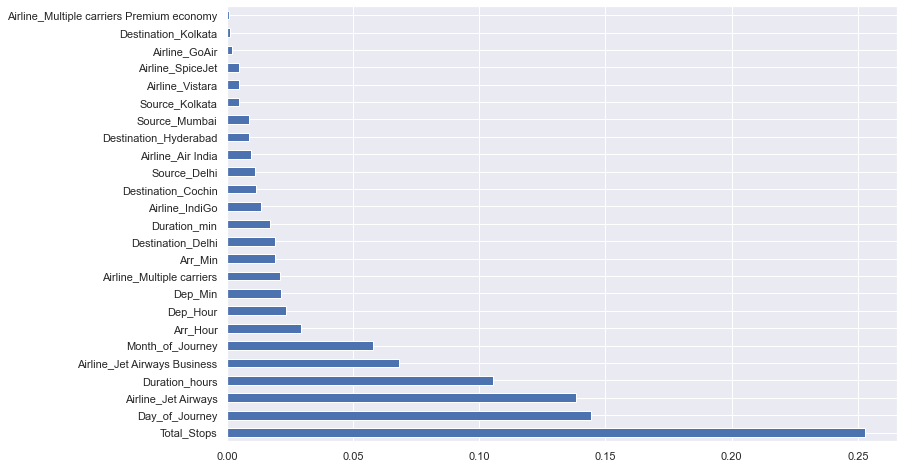

In [52]:
#plot graph of feature importances for better visualization
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

# Saving Processed Data

In [53]:
data_processed.to_excel("Flight_Fare_Prediction_Processed.xlsx",index=False)

# Train Test Split

In [54]:
X=data_processed.drop("Price",axis=1)
y=data_processed.Price

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Fitting the model using Random Forest Algorithm

In [56]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)

RandomForestRegressor()

In [57]:
y_pred = reg_rf.predict(X_test)

In [58]:
reg_rf.score(X_train, y_train)

0.954776768017874

In [59]:
reg_rf.score(X_test, y_test)

0.8033216580560687

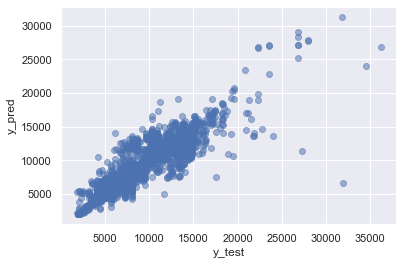

In [60]:
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [61]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 1211.163130717169
MSE: 3876978.516064499
RMSE: 1969.004447954473


In [62]:
metrics.r2_score(y_test, y_pred)

0.8033216580560687

# Hyperparameter Tuning

In [63]:
from sklearn.model_selection import RandomizedSearchCV

In [64]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [65]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [66]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = reg_rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [67]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   6.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   6.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   6.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   6.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   6.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=  11.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=  10.4s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [68]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25}

In [69]:
prediction = rf_random.predict(X_test)

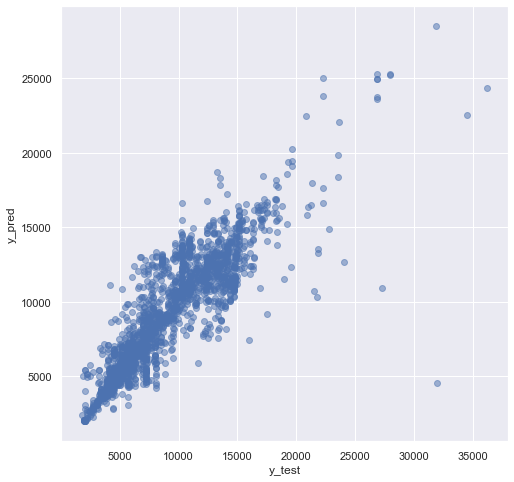

In [70]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [71]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 1297.5284765696554
MSE: 4165890.532382239
RMSE: 2041.051330168411


# Saving Pre-Trained Model

In [72]:
import pickle
# open a file, where you ant to store the data
file = open('Flight_Price_Prediction_Model.pkl', 'wb')

# dump information to that file
pickle.dump(reg_rf, file)

In [73]:
pip freeze> requirements.txt

Note: you may need to restart the kernel to use updated packages.
